# Imports

**fast.ai** This module likely contains a collection of commonly used functions and classes from the fastai library that are made accessible through this import.

In [8]:
from fastai.imports import *

### Loading train.csv 

In [10]:
df = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')
df.head()

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate


...and the `test.csv`:

In [13]:
test_df = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')


Let's go through each column and make sure we understand them.

...starting with `discourse_id`. This is just a unique ID for each "discourse" we are classifying. As we can see, the number of unique `discourse_id`s equals the number of rows in our dataset:

In [14]:
len(df.discourse_id.unique()) == len(df)

True

Looking at the data more closely, it seems like the essays with more data points have basically been annotated very carefully, with like each sentence of the essay having an annotation. On the other hand, when it only has one annotation, it looks like the whole essay is given one annotation. This should be further analyzed.


This code snippet below processes a collection of all training files and calculates the length of each file's content (essentially the number of characters or bytes in the content). 

There are 7 types of discourse that are being annotated here. The data description for the competition provides more details:

> Lead - an introduction that begins with a statistic, a quotation, a description, or some other device to grab the reader’s attention and point toward the thesis
>
> Position - an opinion or conclusion on the main question
>
> Claim - a claim that supports the position
>
> Counterclaim - a claim that refutes another claim or gives an opposing reason to the position
>
> Rebuttal - a claim that refutes a counterclaim
>
> Evidence - ideas or examples that support claims, counterclaims, or rebuttals.
>
> Concluding Statement - a concluding statement that restates the claims

"Evidence" is the most common type of discourse that is being annotated in this dataset.

Finally, let's look at our target variable that we need to predict, `discourse_effectiveness`:

In [15]:
df.discourse_effectiveness.value_counts()

Adequate       20977
Effective       9326
Ineffective     6462
Name: discourse_effectiveness, dtype: int64

There are three options: Ineffective, Effective, and Adequate. The data description provides more info:

>Human readers rated each rhetorical or argumentative element, in order of increasing quality, as one of:
> * Ineffective
> * Adequate
> * Effective

More details on the annotation scheme is provided [here](https://docs.google.com/document/d/1G51Ulb0i-nKCRQSs4p4ujauy4wjAJOae).

We have looked at all the columns from the training CSV. Remember that `discourse_effectiveness` is not in the test CSV since that is what we are predicting but all the other columns are in there. 

We effectively just need to submit the logits from our model for each of the classes. These logits are rescaled to sum up to 1 (so like a softmax) by Kaggle and the metric is calculated. The metric used is a log loss:
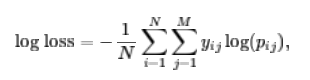

# Training

Here, we'll put together a simple baseline that completely ignores the full essay and only uses the discourse text to make a classification.

Let's import the stuff necessary for training a model. We will be using HuggingFace Transformers to train our model (specifically it's `Trainer` API).

In [16]:
from torch.utils.data import DataLoader
import warnings,transformers,logging,torch
from transformers import TrainingArguments,Trainer
from transformers import AutoModelForSequenceClassification,AutoTokenizer

In [17]:
if iskaggle:
    !pip install --no-index --find-links ../input/huggingface-datasets datasets -q
import datasets
from datasets import load_dataset, Dataset, DatasetDict

Quiet down some of the warnings produced by HuggingFace Transformers:

In [18]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)

DeBERTA v3 Large is a small and simple model good for experimentation. Since we want to submit this notebook, the model is loaded as a dataset so the notebook can stay offline.

In [19]:
model_nm = '../input/debertav3small'

We now get the tokenizer for our model:

In [20]:
tokz = AutoTokenizer.from_pretrained(model_nm)

For our baseline, we will concatenate the discourse type and the discourse text and pass to our model. We need to separate the discourse type and the discourse text so that our model knows which is which. We will use the special separator token that the tokenizer has:

In [21]:
sep = tokz.sep_token
sep

'[SEP]'

Now let's create the input text:

In [22]:
df['inputs'] = df.discourse_type + sep +df.discourse_text

In [23]:
df

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,Adequate,"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,Adequate,"Position[SEP]On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform"
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,Adequate,Claim[SEP]I think that the face is a natural landform because there is no life on Mars that we have descovered yet
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,Adequate,"Evidence[SEP]If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,Adequate,Counterclaim[SEP]People thought that the face was formed by alieans because they thought that there was life on Mars.
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking one person for advice because somebody might give better advice than someone else,Claim,Adequate,Claim[SEP]For many people they don't like only asking one person for advice because somebody might give better advice than someone else
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions on things.,Claim,Adequate,Claim[SEP]also people have different views and opinions on things.
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.,Position,Adequate,Position[SEP]Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.
36763,cc184624ca8e,FFA381E58FC6,"someone can use everything that many people said and use it to help them. Somebody might ask for an opinion of how they look, or what someone thinks of something.\n\nThe person that wants an opinion might want to ask many people because they want to know what is better to do, use, or wear. People always ask for an opinion. Some people do things based on someones' advice because they think it will be better or make the other person happy",Evidence,Ineffective,"Evidence[SEP]someone can use everything that many people said and use it to help them. Somebody might ask for a

HuggingFace expects that the target is in a column to be called `label`, and also that the targets are numerical. We will categorize it and create a new column:

In [24]:
new_label = {"discourse_effectiveness": {"Ineffective": 0, "Adequate": 1, "Effective": 2}}
df = df.replace(new_label)
df = df.rename(columns = {"discourse_effectiveness": "label"})

In [25]:
df

,discourse_id,essay_id,discourse_text,discourse_type,label,inputs
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform.",Lead,1,"Lead[SEP]Hi, i'm Isaac, i'm going to be writing about how this face on Mars is a natural landform or if there is life on Mars that made it. The story is about how NASA took a picture of Mars and a face was seen on the planet. NASA doesn't know if the landform was created by life on Mars, or if it is just a natural landform."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform",Position,1,"Position[SEP]On my perspective, I think that the face is a natural landform because I dont think that there is any life on Mars. In these next few paragraphs, I'll be talking about how I think that is is a natural landform"
2,c22adee811b6,007ACE74B050,I think that the face is a natural landform because there is no life on Mars that we have descovered yet,Claim,1,Claim[SEP]I think that the face is a natural landform because there is no life on Mars that we have descovered yet
3,a10d361e54e4,007ACE74B050,"If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform.",Evidence,1,"Evidence[SEP]If life was on Mars, we would know by now. The reason why I think it is a natural landform because, nobody live on Mars in order to create the figure. It says in paragraph 9, ""It's not easy to target Cydonia,"" in which he is saying that its not easy to know if it is a natural landform at this point. In all that they're saying, its probably a natural landform."
4,db3e453ec4e2,007ACE74B050,People thought that the face was formed by alieans because they thought that there was life on Mars.,Counterclaim,1,Counterclaim[SEP]People thought that the face was formed by alieans because they thought that there was life on Mars.
...,...,...,...,...,...,...
36760,9f63b687e76a,FFA381E58FC6,For many people they don't like only asking one person for advice because somebody might give better advice than someone else,Claim,1,Claim[SEP]For many people they don't like only asking one person for advice because somebody might give better advice than someone else
36761,9d5bd7d86212,FFA381E58FC6,also people have different views and opinions on things.,Claim,1,Claim[SEP]also people have different views and opinions on things.
36762,f1b78becd573,FFA381E58FC6,Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.,Position,1,Position[SEP]Advice is something that can impact a persons view in many ways. It can be helpful or harmful depending on what you say.
36763,cc184624ca8e,FFA381E58FC6,"someone can use everything that many people said and use it to help them. Somebody might ask for an opinion of how they look, or what someone thinks of something.\n\nThe person that wants an opinion might want to ask many people because they want to know what is better to do, use, or wear. People always ask for an opinion. Some people do things based on someones' advice because they think it will be better or make the other person happy",Evidence,0,"Evidence[SEP]someone can use everything that many people said and use it to help them. Somebody might ask for an opinion of how they look, or what someone thinks of something.\n\nThe person that 

Now let's create our `Dataset` object:

In [26]:
ds = Dataset.from_pandas(df)

In [27]:
ds

Dataset({
    features: ['discourse_id', 'essay_id', 'discourse_text', 'discourse_type', 'label', 'inputs'],
    num_rows: 36765
})

To tokenize the data, let's create a function, since that's what `Dataset.map` will need:

In [28]:
def tok_func(x): return tokz(x["inputs"], truncation=True)

Let's see what one example looks like when tokenized:

In [29]:
tok_func(ds[0])

{'input_ids': [1, 8380, 2, 2684, 261, 584, 280, 358, 11759, 261, 584, 280, 358, 446, 264, 282, 898, 314, 361, 291, 812, 277, 7583, 269, 266, 1008, 1311, 9930, 289, 337, 343, 269, 432, 277, 7583, 272, 412, 278, 260, 279, 697, 269, 314, 361, 7658, 681, 266, 1355, 265, 7583, 263, 266, 812, 284, 757, 277, 262, 3568, 260, 7658, 702, 280, 297, 391, 337, 262, 1311, 9930, 284, 994, 293, 432, 277, 7583, 261, 289, 337, 278, 269, 348, 266, 1008, 1311, 9930, 260, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

We can now tokenize the  the input. We'll use `Dataset.map` to speed it up, and remove the columns we no longer need:

In [30]:
inps = "discourse_text","discourse_type"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','discourse_id','essay_id'))

  0%|          | 0/37 [00:00<?, ?ba/s]

Let's see all the columns:

In [31]:
tok_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 36765
})

In [32]:
tok_ds[0].keys()

dict_keys(['label', 'input_ids', 'token_type_ids', 'attention_mask'])

Next we need to split the dataset into a training set and a validation set. We will split based on essays:

In [33]:
essay_ids = df.essay_id.unique()
np.random.seed(42)
np.random.shuffle(essay_ids)
essay_ids[:5]

array(['B5C606F0A883', 'FA4FE7706A1A', '37A77BEAD718', '0ED28D8A5EC4',
       'F25BA634ADDD'], dtype=object)

We'll do a random 80%-20% split:

In [34]:
val_prop = 0.2
val_sz = int(len(essay_ids)*val_prop)
val_essay_ids = essay_ids[:val_sz]

In [35]:
is_val = np.isin(df.essay_id, val_essay_ids)
idxs = np.arange(len(df))
val_idxs = idxs[ is_val]
trn_idxs = idxs[~is_val]
len(val_idxs),len(trn_idxs)

(7181, 29584)

We can use the `select` method of the `Dataset` object to create our splits:

In [36]:
dds = DatasetDict({"train":tok_ds.select(trn_idxs),
             "test": tok_ds.select(val_idxs)})

Here I put all of this into a single function, along with some extra code to deal with the test set (no split necessary):

In [37]:
def get_dds(df, train=True):
    ds = Dataset.from_pandas(df)
    to_remove = ['discourse_text','discourse_type','inputs','discourse_id','essay_id']
    tok_ds = ds.map(tok_func, batched=True, remove_columns=to_remove)
    if train:
        return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})
    else: 
        return tok_ds

We are now ready to train! Let's set some hyperparameters. We select a reasonable LR and a batch size that fits in the GPU RAM. I only train for 1 epoch here.

In [38]:
lr,bs = 8e-5,16
wd,epochs = 0.01,1

We define our metric. Note that technically our metric is the same as our loss function, but I include it here for clarity and teaching purpose:

In [39]:
from sklearn.metrics import log_loss
import torch.nn.functional as F
def score(preds): return {'log loss': log_loss(preds.label_ids, F.softmax(torch.Tensor(preds.predictions)))}

Now we can create our model and trainer. HuggingFace uses the `TrainingArguments` class to set up arguments. We'll use a cosine scheduler with warmup. We'll use fp16 since it's much faster on modern GPUs, and saves some memory. We evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time.

In [40]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=3)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=score)

Let's train!

In [41]:
trainer = get_trainer(dds)
trainer.train()

Epoch,Training Loss,Validation Loss,Log loss
1,0.723600,0.732734,0.732734


TrainOutput(global_step=1849, training_loss=0.771283287432079, metrics={'train_runtime': 498.4898, 'train_samples_per_second': 59.347, 'train_steps_per_second': 3.709, 'total_flos': 1432429988777856.0, 'train_loss': 0.771283287432079, 'epoch': 1.0})

In [42]:
trainer.save_model()

# Inference and Submission

Now we get our test CSV again:

In [43]:
test_df = pd.read_csv('/kaggle/input/feedback-prize-effectiveness/train.csv')

...and process the same way we did with the training set:

In [44]:
test_df['inputs'] = test_df.discourse_type + sep + test_df.discourse_text

In [45]:
test_ds = get_dds(test_df,train=False)

  0%|          | 0/37 [00:00<?, ?ba/s]

Now we have our `Dataset` object with our test dataset. Then we can simply perform `Trainer.predict` on our dataset to get the predictions.

In [46]:
preds = F.softmax(torch.Tensor(trainer.predict(test_ds).predictions)).numpy().astype(float)
preds

array([[0.09154034, 0.79040188, 0.1180578 ],
       [0.10205664, 0.81697303, 0.08097032],
       [0.14841226, 0.81176025, 0.03982746],
       ...,
       [0.018414  , 0.34812587, 0.6334601 ],
       [0.08061615, 0.71154118, 0.20784268],
       [0.30939305, 0.67974782, 0.0108591 ]])